# AttCAT Analysis for CoV Classifier Models

Attentive Class Activation Tokens (AttCAT) on 50 systematically chosen test sequences (Fig. 5D)

In [1]:
from transformers import (
    EsmTokenizer,
    AutoModelForSequenceClassification,
)

import datasets
from datasets import (
    Dataset,
    DatasetDict,
    Sequence,
    Value,
    ClassLabel,
)

import torch
import pandas as pd
import numpy as np

from AttCAT import Explainer

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.ticker as ticker

from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
# models and corresponding test data
cov_dict = {
    n: {
        # replace with actual paths to models/predictions
        "models": {
            "uniform_250k": f"../models/uniform-250k_itr{n}_50ep_HD-CoV",
            "uniform_350k": f"../models/uniform-350k_itr{n}_50ep_HD-CoV",
            "preferential_250k": f"../models/preferential-250k_itr{n}_50ep_HD-CoV",
        },
        "predictions": f"./results/CoV_predictions_itr{n}.csv",
    }
for n in range(5)}

cov_dict

{0: {'models': {'uniform_250k': '../models/uniform-250k_itr0_50ep_HD-CoV',
   'uniform_350k': '../models/uniform-350k_itr0_50ep_HD-CoV',
   'preferential_250k': '../models/preferential-250k_itr0_50ep_HD-CoV'},
  'predictions': './results/CoV_predictions_itr0.csv'},
 1: {'models': {'uniform_250k': '../models/uniform-250k_itr1_50ep_HD-CoV',
   'uniform_350k': '../models/uniform-350k_itr1_50ep_HD-CoV',
   'preferential_250k': '../models/preferential-250k_itr1_50ep_HD-CoV'},
  'predictions': './results/CoV_predictions_itr1.csv'},
 2: {'models': {'uniform_250k': '../models/uniform-250k_itr2_50ep_HD-CoV',
   'uniform_350k': '../models/uniform-350k_itr2_50ep_HD-CoV',
   'preferential_250k': '../models/preferential-250k_itr2_50ep_HD-CoV'},
  'predictions': './results/CoV_predictions_itr2.csv'},
 3: {'models': {'uniform_250k': '../models/uniform-250k_itr3_50ep_HD-CoV',
   'uniform_350k': '../models/uniform-350k_itr3_50ep_HD-CoV',
   'preferential_250k': '../models/preferential-250k_itr3_50ep_HD

In [4]:
# tokenize dataset to also take into account special characters 
def preprocess_dataset(
    batch, 
    tokenizer=None, 
    tokenizer_path="./tokenizer", 
    separator="<cls><cls>",
    max_len=320
) -> list:
    """
    docstring
    """
    # tokenize the H/L sequence pair
    sequences = [h + separator + l for h, l in zip(batch["h_sequence"], batch["l_sequence"])]
    tokenized = tokenizer(sequences, padding="max_length", max_length=max_len, add_special_tokens=True)

    # remove special tokens from attention mask
    input_ids = tokenized.input_ids
    att_mask = tokenized.attention_mask
    special_tokens_mask = [tokenizer.get_special_tokens_mask(val, already_has_special_tokens=True) for val in input_ids]
    att_mask = [[int(not e) for e in m] for m in special_tokens_mask]

    # construct batch
    batch["input_ids"] = input_ids
    batch["attention_mask"] = att_mask
    
    return batch

[[19  8]
 [ 4 19]]

 50


Casting the dataset:   0%|          | 0/50 [00:00<?, ? examples/s]

Filter:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

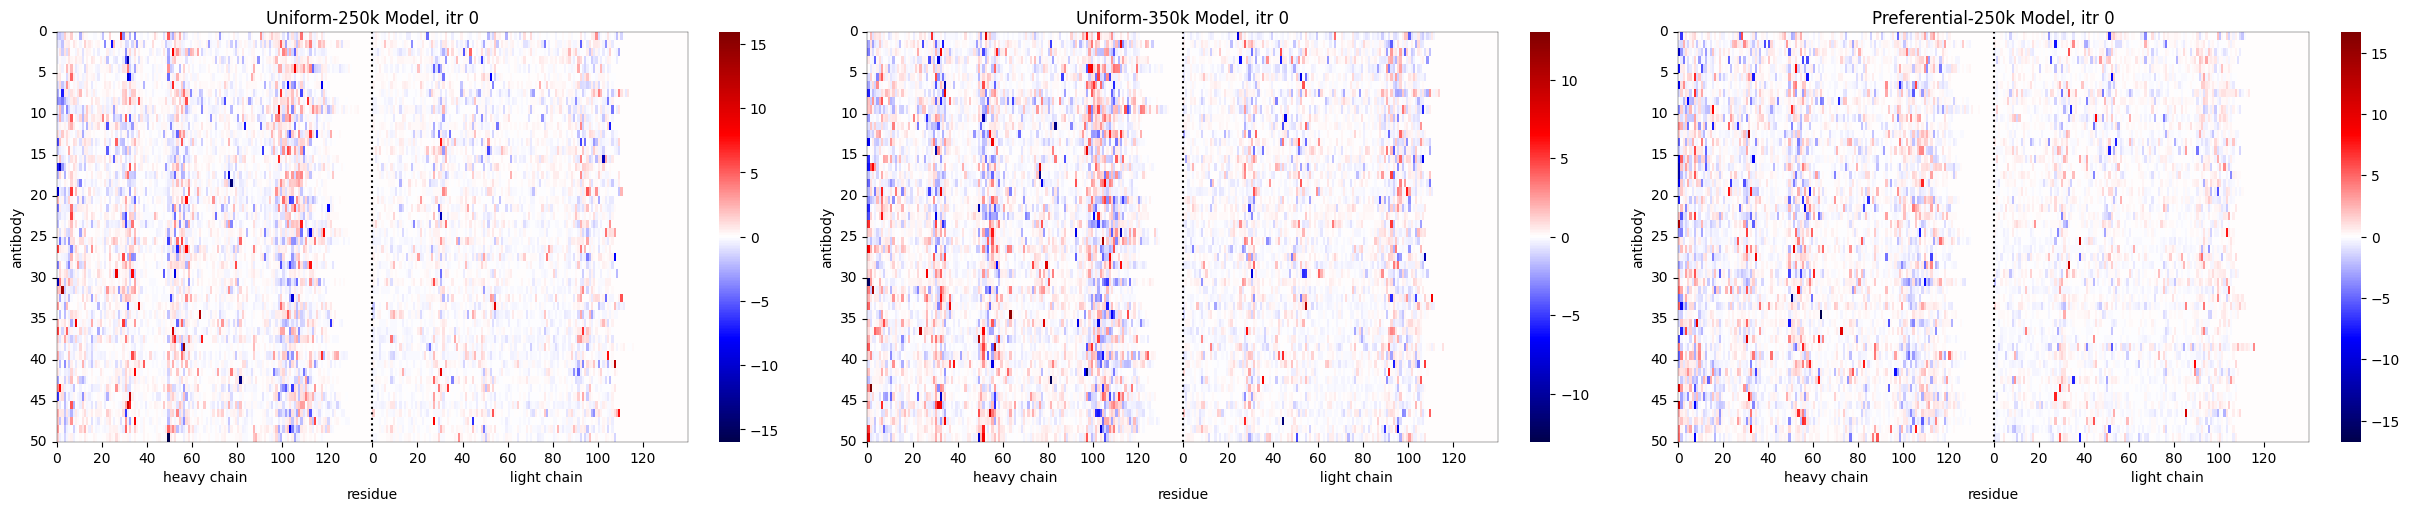

In [5]:
# for each data split (5-fold CV), run attcat on its 3 classifier models on the same test sequences
for itr in cov_dict.keys():
    
    # load test data --> based on sequences that were consistently predicted the same across all 3 models
    data = pd.read_csv(cov_dict[itr]["predictions"])
    data = data.dropna(subset="consistent_prediction")
    # print(confusion_matrix(data["label"], data["consistent_pred"]))

    # systematic selection of 50 test sequences, sort by probability of class 1
    data = data.sort_values(by="avg_probability").iloc[::85][:50]
    
    print(confusion_matrix(data["label"], data["consistent_prediction"]))
    data = data.loc[:, ["label", "name", "h_sequence", "l_sequence", "consistent_category"]]
    data.reset_index(inplace=True, drop=True)
    print("\n", len(data))
    data["consistent_category"].value_counts()
    
    # tokenize
    class_labels = ClassLabel(names=['Healthy-donor', 'CoV-specific'])
    n_classes = len(class_labels.names)
    label2id = {"Healthy-donor": 0, "CoV-specific": 1}
    id2label = {0: "Healthy-donor", 1: "CoV-specific"}
    
    # make huggingface dataset
    dataset = datasets.Dataset.from_pandas(data)
    dataset = dataset.cast_column("label", class_labels)
    
    # filter for length (model has max length of 320 from training)
    filtered = dataset.filter(lambda item: (len(item['h_sequence'])+len(item['l_sequence'])) <= 315) # allows 4 tokens (start, sep (which is 2 tokens long), end)

    # store lengths of heavy and light chains to separate AttCAT scores for plotting
    # length_pad must be a multiple of tick_int for the ticks to properly align
    length_pad = 140
    tick_int = 20
    lengths = [{"name": x["name"],
                "h_len": len(x["h_sequence"]),
                "l_len": len(x["l_sequence"]),
               } for x in filtered]

    # tokenizer
    tokenizer = EsmTokenizer.from_pretrained("../tokenizer/vocab.txt")
    
    # tokenize
    tokenized_dataset = filtered.map(
        preprocess_dataset,
        fn_kwargs={
            "tokenizer": tokenizer,
            "max_len": 320,
        },
        batched=True,
        remove_columns=["name", "h_sequence", "l_sequence", "consistent_category"]
    )

    def run_attcat(model_path, data, tokenizer=tokenizer):
        model = AutoModelForSequenceClassification.from_pretrained(model_path).to(device)
        explainer = Explainer(model)
        n_test = len(data)
        attcats = []
        h = []
        l = []
        for i in tqdm(range(n_test)):
            seq = [data[i]]
            inputs = tokenizer.pad(seq, return_tensors="pt").to(device)
            label = inputs.pop("label")

            # initialize new AttCAT explainer for each sequence
            expl = explainer.AttCAT(
                **inputs,
                norm=True,
            )
            attcats.append(expl)
    
            # separate chains
            h_attcat = expl[1:(lengths[i]["h_len"]+1)]
            h_attcat = np.pad(h_attcat, (0,length_pad-lengths[i]["h_len"]), constant_values=0)
            h.append(h_attcat)
            l_attcat = expl[(lengths[i]["h_len"]+3):(lengths[i]["h_len"]+lengths[i]["l_len"]+3)]
            l_attcat = np.pad(l_attcat, (0,length_pad-lengths[i]["l_len"]), constant_values=0)
            l.append(l_attcat)
    
        del model, explainer
        return attcats, h, l

    # ran attcat for entire dataset on each model
    for model_id, model_path in cov_dict[itr]["models"].items():
        attcats, h, l = run_attcat(model_path, tokenized_dataset)
        cov_dict[itr][f"{model_id}_attcat"] = attcats
        cov_dict[itr][f"h_{model_id}_attcat"] = h
        cov_dict[itr][f"l_{model_id}_attcat"] = l

    # plot
    fig, ax = plt.subplot_mosaic([['a.', 'b.', 'c.']],
                                 layout='constrained',
                                 figsize=(24, 5),
                                 gridspec_kw={"wspace": 0.05, "hspace": 0.05},
                                )
    p = {
        "a.": {"title": "Uniform-250k Model",
               "data": np.concatenate((cov_dict[itr]["h_uniform_250k_attcat"], 
                                       cov_dict[itr]["l_uniform_250k_attcat"]), axis=1)},
        "b.": {"title": "Uniform-350k Model",
               "data": np.concatenate((cov_dict[itr]["h_uniform_350k_attcat"], 
                                       cov_dict[itr]["l_uniform_350k_attcat"]), axis=1)},
        "c.": {"title": "Preferential-250k Model",
               "data": np.concatenate((cov_dict[itr]["h_preferential_250k_attcat"], 
                                       cov_dict[itr]["l_preferential_250k_attcat"]), axis=1)},
    }

    for label, c in p.items():
        sns.heatmap(
            np.array(c["data"]), 
            ax = ax[label], 
            cmap = "seismic", 
            norm = colors.CenteredNorm(vcenter=0.), # set midpoint to middle color
        )
        
        # line to separate heavy and light chains
        ax[label].axvline(x=length_pad, color="k", ls=":")
        
        # for aligned heavy and light chain --> set labels manually, and x axis ticks with wider interval
        x_labels = list(range(0, length_pad, tick_int))*2
        ax[label].set_xticks(np.arange(0, length_pad*2, tick_int), x_labels,
                             rotation="horizontal")

        # y axis ticks with wider interval
        ax[label].set_yticks(np.arange(0, len(filtered)+1, 5), 
                             list(range(0, len(filtered)+1, 5)),
                             rotation="horizontal")
        
        # title
        ax[label].set(title=f"{c['title']}, itr {itr}",
                      xlabel=f"heavy chain{' '*60}light chain\nresidue",  # annotate heavy and light chain in x axis
                      ylabel=f"antibody"
                     )
        
        # subplot labels
        # ax[label].annotate(label, xy=(-0.1, 1.02), xycoords="axes fraction", 
        #                    fontsize=16, weight="bold")

        # border lines
        for _, spine in ax[label].spines.items():
            spine.set_visible(True)
            spine.set_linewidth(0.25)
    
    # plt.savefig(f"./figs/AttCAT_CoV_{itr}.png", bbox_inches='tight')

# note: only iteration 0 is shown here for reference, but above code will repeat for all iterations (cov_dict keys)